# Collaborative filtering using graphical models

In the Yelp dataset, consider each restaurant r to have a latent trait t_r, let each user u have a latent preference pu, let the user’s experience at a restaurant be X_u,r = Normal(t_r * p_u, 1), and suppose the user gives a rating of
two or more stars if X_u,r > 0. Use Gibbs sampling to learn the latent variables t_r and p_u.

In [86]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io, scipy.stats, scipy.linalg
import pandas as pd

In [87]:
# Generate synthetic dataset 
R = 5
U = 20
reviews = list()

for user in range(U):
    num = np.random.choice(range(2, 4), 1)
    num = num[0]
    restaurants = np.random.choice(R, num, replace=False)
    for restaurant in restaurants:
        rating = np.random.choice([1, 2, 3, 4, 5], 1)
        reviews = reviews + [[user, restaurant, rating[0]]]

N = len(reviews)
reviews = np.array(reviews)
print (reviews)

[[ 0  4  4]
 [ 0  1  5]
 [ 0  3  1]
 [ 1  2  4]
 [ 1  3  5]
 [ 1  1  4]
 [ 2  0  5]
 [ 2  1  1]
 [ 3  3  3]
 [ 3  0  4]
 [ 4  4  1]
 [ 4  3  4]
 [ 4  2  2]
 [ 5  4  5]
 [ 5  2  2]
 [ 5  1  3]
 [ 6  1  5]
 [ 6  2  1]
 [ 7  2  1]
 [ 7  1  2]
 [ 8  0  4]
 [ 8  4  5]
 [ 9  3  2]
 [ 9  2  5]
 [ 9  4  2]
 [10  3  2]
 [10  1  2]
 [10  0  1]
 [11  2  3]
 [11  1  4]
 [12  3  2]
 [12  0  4]
 [13  0  5]
 [13  2  1]
 [13  4  4]
 [14  2  5]
 [14  3  5]
 [15  2  3]
 [15  1  3]
 [16  0  2]
 [16  1  1]
 [17  3  1]
 [17  0  4]
 [18  4  4]
 [18  3  5]
 [19  3  1]
 [19  0  1]
 [19  4  4]]


# Process Yelp Dataset

In [4]:
# Import dataset
reviews_df = pd.read_csv("Users200reviews/reviews.csv")
users_df = pd.read_csv("Users200reviews/users.csv")
restaurants_df = pd.read_csv("Users200reviews/business.csv")


In [6]:
reviews_df = reviews_df.sample(frac=1).reset_index(drop=True)
R = restaurants_df.values.shape[0]
U = users_df.values.shape[0]

print (R)
print (U)

442
1013


In [7]:
reviews = np.array(reviews_df[['user_id', 'business_id', 'stars']].values)

for review in reviews:
    review[0] = users_df.index[users_df.id == review[0]].values[0]
    review[1] = restaurants_df.index[restaurants_df.id == review[1]].values[0]
reviews = reviews.astype(int)

In [8]:
reviews.shape

(14627, 3)

# Visualize data

Distribution of the stars given by the users in the chosen dataset. 

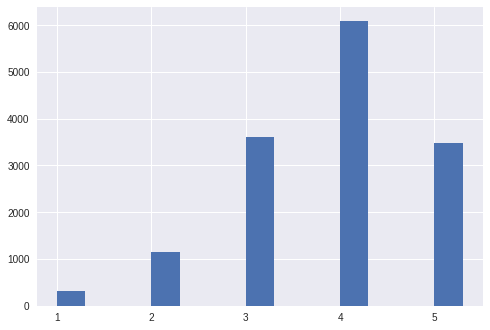

In [9]:
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(reviews_df['stars'].values, [1, 1.3, 2, 2.3, 3, 3.3, 4, 4.3, 5, 5.3])
plt.show()

# Modeling a single trait and a binary outcome

Assumptions:

    1) Each restaurant can be characterised by its position on the trait line (represented as a continuous number).
    
    2) Each person's preference can be characterised by its position on the trait line (represented as a continuous number).
    
    3) A positive preference value means that the person prefers restaurants with positive values of the trait (and vice versa for negative values). The absolute size of the preference value indicates the strength of preference, where zero means indifference.
    
    4) Whether a person will like or dislike a restaurant depends only on the restaurant’s traits and not on anything else.

Perform Gibbs sampling:
    
    1) Sample user experience X from conditional posterior
    
    2) Sample restaurant traits from conditional posterior
    
    3) Sample user preferences from conditional posterior

In [11]:
def rejection_sampling(mu, std, rating):
    if rating>3:
        sign = 1
    else: 
        sign = -1
    while True:
        x = np.random.normal(loc=mu, scale=std)
        if np.sign(x)==sign:
            return x
    

def Gibbs_sampling_single_trait_binary_rating(reviews):

    pv_t = np.ones(R)   # prior variance for restaurant traits
    t = np.zeros(R)     # restaurant traits, initialized to be the prior mean mu_0 = 0

    pv_p = np.ones(U)   # prior variance for user preferences
    p = np.zeros(U)     # user preferences, initialized to be the prior mean mu_0 = 0

    x = np.zeros(reviews.shape[0]) 
    
    restaurant_traits_samples = []
    user_preferences_samples = []

    for num in range(2000):
        
        if num%250==0:
            print (num)
        
        # Sample user experience (x) given user preferences (p), restaurant traits (t) and rating (y)
        for r in range(reviews.shape[0]):
            s = p[reviews[r][0]] * t[reviews[r][1]]
            x[r] = rejection_sampling(s, 1, reviews[r][2])
            
        # Sample each restaurant trait (t) given user experiences (x)
        t = np.zeros(R) 
        for i in range(R):
            var_inv = 1/pv_t[i] + (np.square(p[reviews[:, 0]]) * (reviews[:, 1]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * p[reviews[:,0]] * ((reviews[:, 1] == i).astype(int))).sum() 
            mu = var * mu_tilde
            t[i] = np.random.normal(loc=mu, scale=np.sqrt(var))
    
        # Sample user preferences (p) given user experience (x)
        p = np.zeros(U)  
        for i in range(U):
            var_inv = 1/pv_p[i] + (np.square(t[reviews[:, 1]]) * (reviews[:, 0]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * t[reviews[:,1]] * ((reviews[:, 0] == i).astype(int))).sum() 
            mu = var * mu_tilde
            p[i] = np.random.normal(loc=mu, scale=np.sqrt(var))

        restaurant_traits_samples.append(t)
        user_preferences_samples.append(p)

    restaurant_traits_samples = np.array(restaurant_traits_samples)
    user_preferences_samples = np.array(user_preferences_samples)
    
    return restaurant_traits_samples, user_preferences_samples

In [12]:
train_reviews = reviews[:12000]
test_reviews = reviews[12000:]

In [ ]:
restaurant_traits_samples, user_preferences_samples = Gibbs_sampling_single_trait_binary_rating(train_reviews)

# Burning time for Gibbs sampler

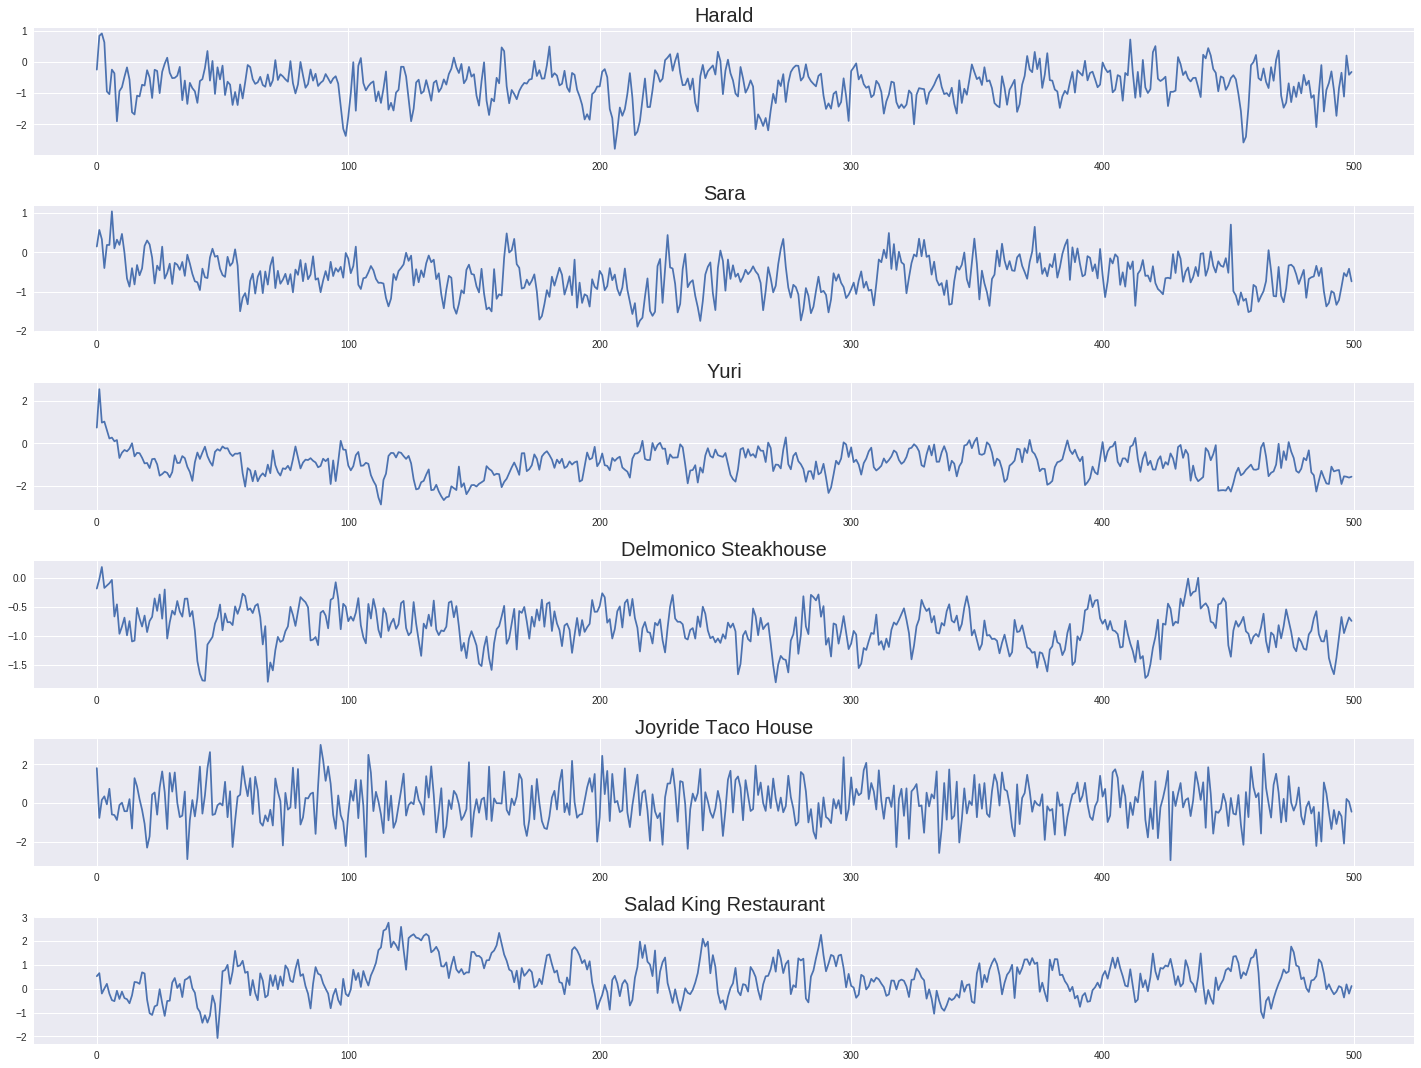

In [37]:
users = [0, 1, 2]
restaurants = [0, 1, 2]

with matplotlib.rc_context({'figure.figsize': [20,15], 'axes.titlesize': 20}):
    fig = plt.figure()
    for i in range(3):
        ax = fig.add_subplot(6, 1, i+1)
        fig.tight_layout()
        ax.plot(user_preferences_samples[:500, users[i]])
        ax.set_title(users_df.get_value(users[i], 'name'))
    for i in range(3):
        ax = fig.add_subplot(6, 1, i+4)
        fig.tight_layout()
        ax.plot(restaurant_traits_samples[:500, restaurants[i]])
        ax.set_title(restaurants_df.get_value(restaurants[i], 'name'))
plt.show()

The burning time represents the time required to get from the initial random location in the Gibbs sampler to a location that has a high probability under the posterior. By looking at the user preferences and restaurant traits for each iteration we can notice that the burning time is about 40 iterations. 

# Mixing time for Gibbs sampler

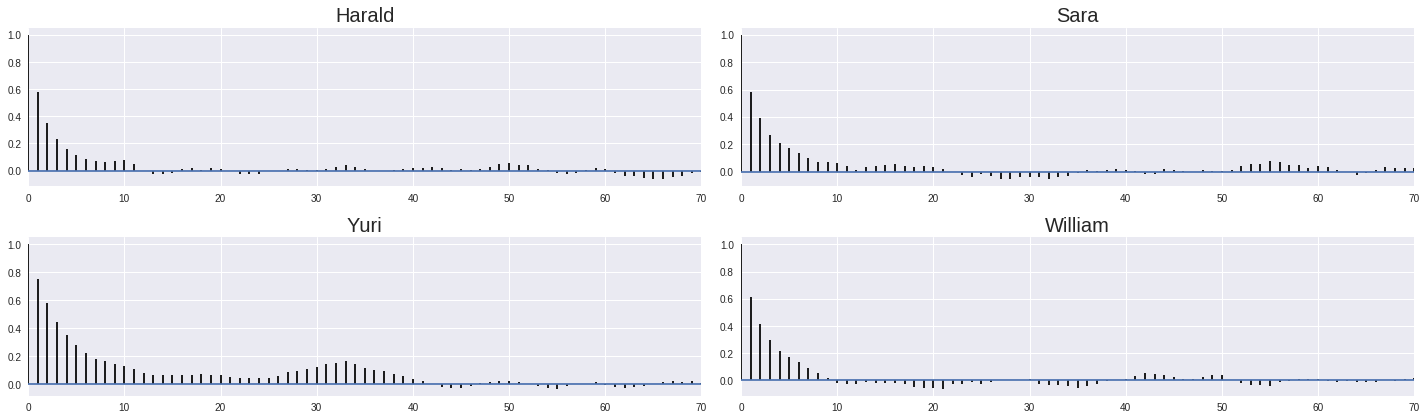

In [42]:
users = [0, 1, 2, 3]

with matplotlib.rc_context({'figure.figsize': [20,6], 'axes.titlesize': 20}):
    fig = plt.figure()
    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1)  # 2 rows of panels, 3 columns
        fig.tight_layout()
        ax.acorr(user_preferences_samples[:, users[i]] - np.mean(user_preferences_samples[:, users[i]]), maxlags=70)
        ax.set_title(users_df.get_value(users[i], 'name'))
        ax.set_xlim(0,70)
plt.show()

Conversely, the mixing time is given by the time required for the samples to become uncorrelated. By looking at the autocorrelation plots, we can say that the mixing time is about 15-20 iterations.

# Ranked user preferences 

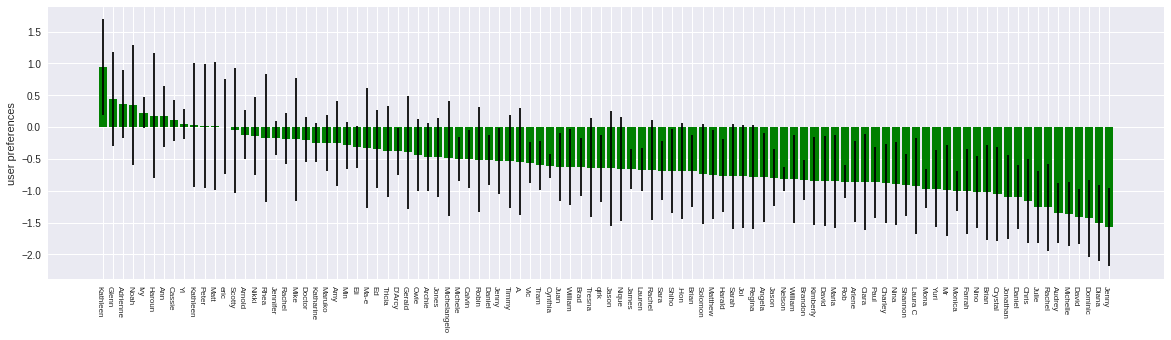

In [44]:
mean_preferences = np.mean(user_preferences_samples[50:], axis=0)[:100]
std_preferences = np.std(user_preferences_samples[50:], axis=0)[:100]
rank_order = np.argsort(mean_preferences)[::-1]

with matplotlib.rc_context({'figure.figsize': [20,5], 'xtick.labelsize': 8}):
    x = np.arange(100)
    plt.bar(x, mean_preferences[rank_order], align='center', width=.8, yerr=std_preferences[rank_order], color='green')
    plt.xticks(x, users_df.iloc[rank_order]['name'].values, rotation=-90, ha='right')
    plt.ylabel('user preferences')
plt.show()

# Ranked restaurant traits

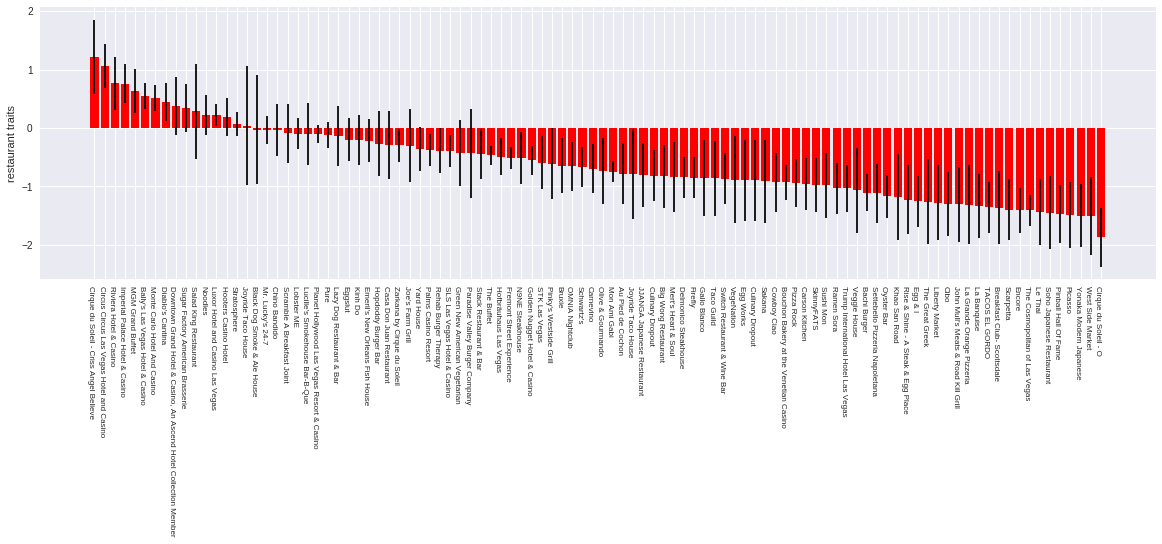

In [18]:
mean_traits = np.mean(restaurant_traits_samples[50:], axis=0)[:100]
std_traits = np.std(restaurant_traits_samples[50:], axis=0)[:100]
rank_order = np.argsort(mean_traits)[::-1]

with matplotlib.rc_context({'figure.figsize': [20,5], 'xtick.labelsize': 8}):
    x = np.arange(100)
    plt.bar(x, mean_traits[rank_order], align='center', width=.8, yerr=std_traits[rank_order], color='red')
    plt.xticks(x, restaurants_df.iloc[rank_order]['name'].values, rotation=-90, ha='right')
    plt.ylabel('restaurant traits')
plt.show()

# Scatter plot user preferences and restaurant traits on the trait line

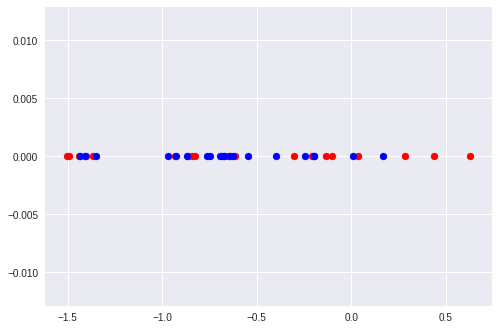

In [50]:
plt.scatter(mean_traits[:20], np.zeros(20), color='red')
plt.scatter(mean_preferences[:20], np.zeros(20), color='blue')
plt.show()

# Evaluate accuracy of predicting correct rating on test reviews 

In [59]:
mean_preferences = np.mean(user_preferences_samples, axis=0)
mean_traits = np.mean(restaurant_traits_samples, axis=0)

num_test_reviews = test_reviews.shape[0]
num = 0
for test_review in test_reviews:
    user_preference = mean_preferences[test_review[0]]
    restaurant_trait = mean_traits[test_review[1]]
    experience = user_preference * restaurant_trait
    
    if test_review[2] > 3:
        sign = 1
    else:
        sign = -1
    
    if np.sign(experience) == sign:
        num = num + 1

print (float(num)/float(num_test_reviews))
    

0.681766273315569


The current model achieves about 70% accuracy on predicting whether a person will like a restaurant or not. 

# Modeling multiple traits and a binary outcome

Assumptions:

    1) Each restaurant can be characterised by its position in the trait space (represented as a continuous number for each trait).
    
    2) Each person's preference can be characterised by its position in the trait space (represented as a continuous number for each trait).
    
    3) A positive preference value means that the person prefers restaurants with positive values of the trait (and vice versa for negative values). The absolute size of the preference value indicates the strength of preference, where zero means indifference.
    
    4) The effect of one trait value on whether a person likes or dislikes a restaurant is the same, no matter what other trait values that restaurant has.
    
    5) Whether a person will like or dislike a restaurant depends only on the restaurant’s traits and not on anything else.

Perform Gibbs sampling:
    
    1) Sample user experience X from conditional posterior
    
    2) Jointly sample restaurant traits from conditional posterior
    
    3) Jointly sample user preferences from conditional posterior

In [ ]:
def rejection_sampling(mu, std, rating):
    if rating>3:
        sign = 1
    else: 
        sign = -1
    while True:
        x = np.random.normal(loc=mu, scale=std)
        if np.sign(x)==sign:
            return x
    

def Gibbs_sampling_multiple_traits_binary_rating(reviews, K):

    pv_t = np.ones((R, K)   # prior variance for restaurant traits
    t = np.zeros((R, K))     # restaurant traits, initialized to be the prior mean mu_0 = 0

    pv_p = np.ones((U, K))   # prior variance for user preferences
    p = np.zeros((U, K))     # user preferences, initialized to be the prior mean mu_0 = 0

    x = np.zeros(reviews.shape[0]) 
    
    restaurant_traits_samples = []
    user_preferences_samples = []

    for num in range(2000):
        
        if num%250==0:
            print (num)
        
        # Sample user experience (x) given user preferences (p), restaurant traits (t) and rating (y)
        for r in range(reviews.shape[0]):
            s = p[reviews[r][0]] * t[reviews[r][1]]
            x[r] = rejection_sampling(s, 1, reviews[r][2])
            
        # Sample each restaurant trait (t) given user experiences (x)
        t = np.zeros(R) 
        for i in range(R):
            var_inv = 1/pv_t[i] + (np.square(p[reviews[:, 0]]) * (reviews[:, 1]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * p[reviews[:,0]] * ((reviews[:, 1] == i).astype(int))).sum() 
            mu = var * mu_tilde
            t[i] = np.random.normal(loc=mu, scale=np.sqrt(var))
    
        # Sample user preferences (p) given user experience (x)
        p = np.zeros(U)  
        for i in range(U):
            var_inv = 1/pv_p[i] + (np.square(t[reviews[:, 1]]) * (reviews[:, 0]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * t[reviews[:,1]] * ((reviews[:, 0] == i).astype(int))).sum() 
            mu = var * mu_tilde
            p[i] = np.random.normal(loc=mu, scale=np.sqrt(var))

        restaurant_traits_samples.append(t)
        user_preferences_samples.append(p)

    restaurant_traits_samples = np.array(restaurant_traits_samples)
    user_preferences_samples = np.array(user_preferences_samples)
    
    return restaurant_traits_samples, user_preferences_samples

# Modeling single trait and star ratings

Assumptions:

    1) Each restaurant can be characterised by its position in the trait space (represented as a continuous number for each trait).
    
    2) Each person's preference can be characterised by its position in the trait space (represented as a continuous number for each trait).
    
    3) A positive preference value means that the person prefers restaurants with positive values of the trait (and vice versa for negative values). The absolute size of the preference value indicates the strength of preference, where zero means indifference.
    
    4) The effect of one trait value on whether a person likes or dislikes a restaurant is the same, no matter what other trait values that restaurant has.
    
    5) Whether a person will like or dislike a restaurant depends only on the restaurant’s traits and not on anything else.
    
    6) When two people have the same user experience for a restaurant, they will give it the same number of stars.

In [97]:
def rejection_sampling_user_experience(mu, std, rating, threshold):
    while True:
        x = np.random.normal(loc=mu, scale=std)
        if rating==5:
            if np.sign(x-threshold[5])==1:
                return x
        if rating==1:
            if np.sign(x-threshold[2])==-1:
                return x
        if np.sign(x-threshold[rating])==1 and np.sign(x-threshold[rating+1])==-1:
                return x
        
        
def rejection_sampling_star_threshold(star, x, reviews, mu, std):
    while True:
        threshold = np.random.normal(loc=mu, scale=std)
        if ((np.sign(x-threshold)==1).astype(int) * (reviews[:, 2]==star).astype(int)).prod() == 1:
            return threshold

def Gibbs_sampling_single_trait_star_rating(reviews):

    pv_t = np.ones(R)   # prior variance for restaurant traits
    t = np.zeros(R)     # restaurant traits, initialized to be the prior mean mu_0 = 0

    pv_p = np.ones(U)   # prior variance for user preferences
    p = np.zeros(U)     # user preferences, initialized to be the prior mean mu_0 = 0
    
    pv_h = 5 * np.ones(6)
    pm_h = np.array([0, -100, -0.5, 0, 0.5, 1])
    
    h = np.array([0, -100, -0.5, 0, 0.5, 1])
    
    x = np.zeros(reviews.shape[0]) 
    
    star_threshold_samples = []
    restaurant_traits_samples = []
    user_preferences_samples = []

    for num in range(5):
          
       # Sample star thresholds h2, h4 and h5 given user preferences (p), restaurant traits (t), user_experiences (x) and rating (y)
        h = np.zeros(6)  
        h[2] = rejection_sampling_star_threshold(2, x, reviews, 0, 5)
        h[4] = rejection_sampling_star_threshold(4, x, reviews, 0, 5)
        h[5] = rejection_sampling_star_threshold(5, x, reviews, 0, 5)
        print (h)
    
    
        # Sample user experience (x) given user preferences (p), restaurant traits (t), star thresholds (h) and rating (y)
        for r in range(reviews.shape[0]):
            s = p[reviews[r][0]] * t[reviews[r][1]]
            x[r] = rejection_sampling_user_experience(s, 1, reviews[r][2], h)  
        print (x)
        
        
        # Sample each restaurant trait (t) given user experiences (x)
        t = np.zeros(R) 
        for i in range(R):
            var_inv = 1/pv_t[i] + (np.square(p[reviews[:, 0]]) * (reviews[:, 1]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * p[reviews[:,0]] * ((reviews[:, 1] == i).astype(int))).sum() 
            mu = var * mu_tilde
            t[i] = np.random.normal(loc=mu, scale=np.sqrt(var))
    
        # Sample user preferences (p) given user experience (x)
        p = np.zeros(U)  
        for i in range(U):
            var_inv = 1/pv_p[i] + (np.square(t[reviews[:, 1]]) * (reviews[:, 0]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * t[reviews[:,1]] * ((reviews[:, 0] == i).astype(int))).sum() 
            mu = var * mu_tilde
            p[i] = np.random.normal(loc=mu, scale=np.sqrt(var))

        star_threshold_samples.append(h)
        restaurant_traits_samples.append(t)
        user_preferences_samples.append(p)

    star_threshold_samples = np.array(star_threshold_samples)
    restaurant_traits_samples = np.array(restaurant_traits_samples)
    user_preferences_samples = np.array(user_preferences_samples)
    
    return star_threshold_samples, restaurant_traits_samples, user_preferences_samples

In [98]:
star_threshold_samples, restaurant_traits_samples, user_preferences_samples = Gibbs_sampling_single_trait_star_rating(reviews)

KeyboardInterrupt: 